# This sim is configured for HERMES pi+ data
### This can simply be run as a notebook
### The data from the sim has been saved and will automatically be loaded for plotting


In [1]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as py
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
from functools import partial, reduce
from itertools import combinations
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import percentileofscore
%matplotlib inline 

In [2]:
files = files = ['1000.xlsx','1001.xlsx','1002.xlsx','1003.xlsx','1004.xlsx','1005.xlsx',
         '1006.xlsx','1007.xlsx','1008.xlsx','1009.xlsx']
path = '~/GIT/collinearity/database/sidis/expdata/'
for F in files:
    if F == '1000.xlsx':
        data = pd.read_excel(path + F)
    else:
        data = pd.concat([data,pd.read_excel(path + F)],ignore_index=True,sort = True)

data = data.query("col == 'hermes' and hadron == 'pi+'")
data.reset_index(inplace=True,drop=True) # Gets rid of any gaps in index and is crucial for this notebook

#for i in range(len(data)):print(data.index[i]) 

In [3]:
class Rfilter(object):

    def __init__(self, hadron='pi+', fudge=[0, 0]):
        self.M = 0.938
        self.M2 = self.M**2
        self.set_Mh(hadron)
        

        self.fudge1 = fudge[0]
        self.fudge2 = fudge[1]

        self.MiT2 = 0.5 + 0.3 * fudge[0]
        self.MfT2 = 0.5 + 0.3 * fudge[1]
        self.kT = 0
    
        self.MX = 1.3
        self.Ma = 1.5
        self.Mb = 0.3
        self.deltaM = 0.3
        self.MJ = 0.3
        
        self.MiT = self.MiT2**0.5
        self.MfT = self.MfT2**0.5
        self.kT2 = self.kT**2
        
        # from paper, we need kf2, deltakT2, ki2
        # we need to have a way to vary them!
        self.kf       = 0
        self.ki       = 0
        self.kf2      = self.kf**2
        self.ki2      = self.ki**2
        self.deltakT  = 0
        self.deltakT2 = self.deltakT**2
    def set_ki(self,ki):
        self.ki = ki
        self.ki2 = ki**2
    def set_kf(self,kf):
        self.kf = kf
        self.kf2 = kf**2
    def set_kT(self,kT):
        self.kT = kT
        self.kT2 = kT**2
    def set_deltakT(self,deltakT):
        self.deltakT = deltakT
        self.deltakT2 = self.deltakT**2
    def set_Mh(self, hadron):
        if hadron == 'pi+':
            self.Mh = 0.135  #  
        if hadron == 'pi-':
            self.Mh = 0.135  #  
        if hadron == 'pi0':
            self.Mh = 0.135  #  
        if hadron == 'k+':
            self.Mh = 0.493
        if hadron == 'k-':
            self.Mh = 0.493
        if hadron == 'k0':
            self.Mh = 0.493
        self.Mh2 = self.Mh**2
    
    def get_ki2(self):
        return self.ki2
    def get_kf(self):
        return self.kf
    
    def get_W2(self, x, Q2):
        W2 = Q2 * (1. - x) / x + self.M2
        return W2

    def get_MBT(self, PhT):
        MBT = np.sqrt( self.Mh2 + PhT**2 )
        return MBT
        
    def get_MiT(self, x, Q2):
        xn = self.get_xn(x, Q2)
#    self.MiT = np.sqrt( (xn*self.kT**2 + xn*self.MX**2 - (1-xn)*xn*self.M2)/(1-xn) )
        self.MiT = np.sqrt((xn * self.kT**2 + xn * (self.Ma + self.Mb / np.sqrt(xn))
                            ** 2 - (1 - xn) * xn * self.M2 + self.deltaM**2 * self.fudge1) / (1 - xn))
        return self.MiT

    def get_MfT(self):
        self.MfT = np.sqrt(self.kT**2 + self.MJ**2 +
                           self.deltaM**2 * self.fudge2)
        return self.MfT

    def get_xn(self, x, Q2):
        return 2 * x / (1 + np.sqrt(1 + 4 * x**2 * self.M2 / Q2))

    def get_yh(self, x, z, Q2, PhT, hadron, sign=-1):
        xn = self.get_xn(x, Q2)
        self.set_Mh(hadron)
        expy = Q2**0.5 * z * (Q2 - xn**2 * self.M2)\
            / (2 * self.M2 * xn**2 * (self.Mh2 + PhT**2)**0.5)\
            + sign * Q2**0.5 / (xn * self.M) * (z**2 * (Q2 - xn**2 * self.M2)**2
                                        / (4 * self.M2 * xn**2 * (self.Mh2 + PhT**2)) - 1)**0.5
        return np.log(expy)


    # zn
    def get_zn(self, x, z, Q2, PhT, hadron):
        xn = self.get_xn(x,Q2)
        self.set_Mh(hadron)
        MBT = self.get_MBT(PhT)
        zn =  xn * z/ (2 * x) * ( 1. + np.sqrt( 1.- 4. * self.M2 * MBT**2 * x**2 /  ( Q2**2 * z**2) ) )
        return zn
        
# rapidity of the target

    def get_yp(self, x, Q2):
        xn = self.get_xn(x, Q2)
        return np.log(np.sqrt(Q2) / (xn * self.M))

    def get_yi(self, Q2):
        return 0.5 * np.log(Q2 / self.MiT**2)

    def get_yf(self, Q2):
        return -0.5 * np.log(Q2 / self.MfT**2)

    def get_MhT(self, PhT):
        return np.sqrt(self.Mh2 + PhT**2)

    def get_R(self, x, z, Q2, PhT, hadron):
        self.set_Mh(hadron)
        MfT = self.get_MfT()
        MiT = self.get_MiT(x, Q2)
        yi = self.get_yi(Q2)
        yf = self.get_yf(Q2)
        MhT = self.get_MhT(PhT)
        yh = self.get_yh(x, z, Q2, PhT, hadron)
        zn = self.get_zn(x, z, Q2, PhT, hadron)
        znhat = zn/z
        # from paper..
        Ph_kf = 0.5 * MhT * MfT * (np.exp(yf - yh) + np.exp(yh - yf)) - znhat/zn * PhT**2 - PhT * self.kT
        Ph_ki = 0.5 * MhT * MiT * (np.exp(yi - yh) - np.exp(yh - yi)) - PhT * self.kT
        return np.abs(Ph_kf / Ph_ki)

        
# R0, Eq. (4.14)...
    def get_R0(self, Q2):
        """
        Collinearity ratio defined in the paper Eq. (4.15)
        """
        return  np.maximum(np.maximum(self.ki2/Q2,self.kf2/Q2),self.kT2/Q2)
        
        
# We call R1 in the new paper what was R in the previous...
    def get_R1(self, x, z, Q2, PhT, hadron):
        """
        Collinearity ratio defined in the paper Eq. (4.15)
        """
        return  self.get_R( x, z, Q2, PhT, hadron)  

# R2 from Eq. (4.17)        
    def get_R2(self, x, z, Q2, PhT, hadron):
        self.set_Mh(hadron)
        zn = self.get_zn(x, z, Q2, PhT, hadron)
        znhat = zn/z
        qT = -PhT/zn
        # from paper..
        return np.abs( -(1.-znhat) - znhat*qT**2/Q2 - (1.-znhat)*self.kf2/(znhat*Q2) - \
                      self.deltakT2/(znhat*Q2) + 2.*qT*self.deltakT/Q2 )

# Proximity is defined for a sphere of a selected radius(p) by the following function
def Proximity(data,domain,p,hadron,fudge):
    """
    data   = any Pandas DataFrame should do as long as it contains x,z,Q2, and pT
    domain = an array of values you wish to extract R0,R1,R2 
    p      = radius of sphere representing the demarcation of the proximity
    hadron = any hadron found in the data
    fudge  = idk what fudge is so I did the right thing and passed it along 
    """
    
    data['proximity'] = 0.
    Rval = Rfilter(hadron = hadron,fudge=fudge)
    
    for i in range(1,len(data)):
        inside = 0.
        outside = 0.
        for ki in domain:
            Rval.set_ki(ki)
            for kf in domain:
                Rval.set_kf(kf)
                for kT in domain:
                    Rval.set_kT(kT)
                    Rval.set_deltakT(kT)
            
                    R0 = Rval.get_R0(data.loc[i,'Q2'])
                    R1 = Rval.get_R1(data.loc[i,'x'],data.loc[i,'z'],data.loc[i,'Q2'],data.loc[i,'pT'], \
                                     hadron = hadron)
                    R2 = Rval.get_R2(data.loc[i,'x'],data.loc[i,'z'],data.loc[i,'Q2'],data.loc[i,'pT'], \
                                     hadron = hadron)
                    p2 = R0**2 + R1**2+ R2**2
                    
                    if p2 < 1:
                        inside += 1.
                        
                    else:
                        outside += 1.
    
        data.loc[i,'proximity'] = inside/(inside+outside)
        
    return data

In [4]:
domain = np.linspace(0.05,0.8,4)
dat = Proximity(data,domain,p=1,hadron = 'pi+',fudge = [0,0])

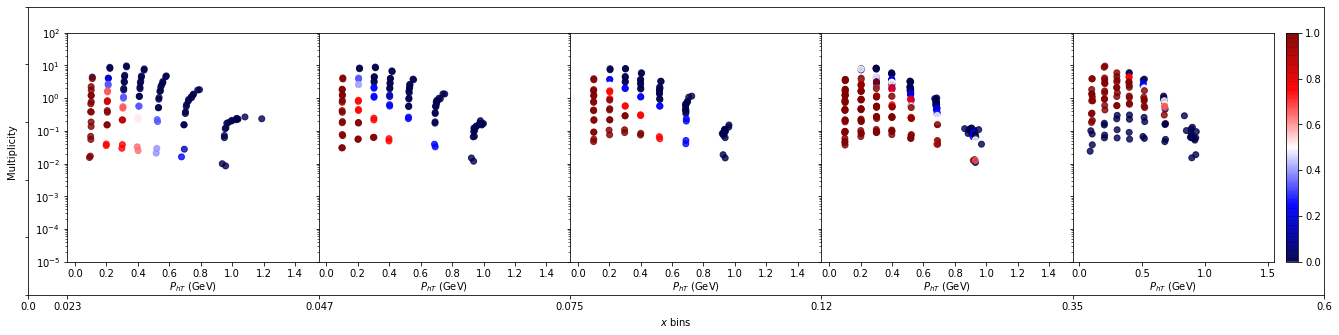

In [5]:
####################
# Hermes pi+ Plot  #
####################  

#dat = pd.read_excel('HERMES_pi+_proximity.xlsx')

xBin = np.array([0.023,0.047,0.075,0.12,0.35,0.6]) # Bins for x used to plot Pt
Q2Bin = np.array([1.0,10]) # **NOTE** includes all Q2 data, therefore all value data is plotted vs. Pt
zBin = np.array([0.1, 0.2,0.25,0.3, 0.375, 0.475, 0.6, 0.8, 1.1]) # catagories for z to be plotted individually 
                                                                 # in each subplot
Phperp = np.array([ 0.0, 0.15, 0.25, 0.35, 0.45, 0.6, 0.8, 1.2]) 

# Binning data
dat['xBin'] = pd.cut(dat['x'], xBin,labels = False, retbins=0)
dat['Q2Bin'] = pd.cut(dat['Q2'], Q2Bin,labels = False, retbins=0)
dat['zBin'] = pd.cut(dat['z'], zBin,labels = False, retbins=0)

# Bins for x and y that have non-empty intersection
pTdat = [0,1,2,3,4] # xBins that overlap Q2Bins
valuedat = [0] # Q2bins that overlap xBins
 
# Initialize the figure
fig1 = plt.figure(figsize=(18, 4),facecolor="white") 
globalGrid = gridspec.GridSpec(1, 1,left=0.03,right=1,top=.91,bottom=.115, 
                             wspace=0.0, hspace=0.0) # plot for subplot matrix as 1x1 matrix
innerGrid = gridspec.GridSpecFromSubplotSpec(1,5, subplot_spec=globalGrid[0], 
                             wspace=0.0, hspace=0.0) # 1X5 subplot grid 

# Figure properties
ax = fig1.add_axes([0,0,1,1]) 
ax.xaxis.set_ticks([0,.3,2.245,4.18,6.12,8.06,10 ])
xticklabels = np.array([0,0.023,0.047,0.075,0.12,0.35,0.6]) 
ax.set_yticklabels("")
ax.set_xticklabels(xticklabels)
ax.set_xlabel(r"$x$ bins") 
ax.set_ylabel(r"Multiplicity")


for f,F in zip(range(len(pTdat)),pTdat):       
    for j,J in zip(range(len(valuedat)),valuedat):
        
        ax = fig1.add_subplot(innerGrid[f]) # add subplot in innerGrid
        
        for z in range(len(zBin)-1): 
           
            databin = dat[dat['xBin'].isin([F]) & dat['Q2Bin'].isin([J]) & dat["zBin"].isin([z])]
            
            if f != 0:
               
                ax.scatter(databin['pT'],databin['value'], c=databin['proximity'],
                           cmap=plt.get_cmap('seismic'), alpha=0.8)
                ax.set_xlim([-0.05,1.55])
                ax.set_ylim([10**(-5),10**2])
                ax.set_xlabel(r"$P_{hT}$ (GeV)",labelpad=1)
                ax.set_yscale('log')
                ax.set_yticklabels('')
               
            else:
              
                plot = ax.scatter(databin['pT'],databin['value'], c=databin['proximity'], 
                                  cmap=plt.get_cmap('seismic'), alpha=0.8)
                ax.set_xlabel(r"$P_{hT}$ (GeV)",labelpad=1)
                ax.set_xlim([-0.05,1.55])
                ax.set_ylim([10**(-5),10**2])
                ax.set_yscale('log')
                
fig1.colorbar(plot)
plt.show()
#plt.savefig('HERMES_pi+_proximity.png', bbox_inches = "tight")
#dat.to_excel('HERMES_pi+_proximity.xlsx')